In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In this notebook we'll be training the same neural net on two different tasks sequentially. This should help drive home the notion that "what a neural network does" is determined entirely by its weights.

We'll be working through 2 computer vision tasks and training a small neural network to recognize digits, as well as fashion items in the second iteration.

The main point of this notebook and the associated exercise is to demonstrate the point that the performance of neural networks is determined entirely by their weights and also to familiarize you with the general NN training and prediction process.

# Hyperparameters

Yet another bit of Jargon. Because "parameters" is used interchangeably with "weights", the term "hyperparameters" is used to refer to adjustable parameters of the training process. Hyperparameter tuning is probably the most important part of achieving high performance with Neural Networks. It's also something of a black art, as there isn't a predictive theory of neural networks which predicts how performance will change based on how Hyperparameters are changed. Choosing good hyperparameters is still, unfortunately, an intuitive and empirical process.

In [ ]:
# How many samples to include in each iteration of the
# Predict -> Measure Performance -> Adjust Weights cycle
batch_size = 64

# How many times we want to show the entire dataset to the NN
epochs = 10

# How much we want to adjust weights by. This is the most important
# hyperparameter by far.
lr = 1e-3

# I've used a one cycle policy (oscillating LR) to help achieve 
# better performance. This is the upper bound for how high the LR
# will go.
max_lr = 4e-3

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


# Data prep

Datasets are a pytorch abstraction, but you'll find that regardless of what tensor library you use, you'll probably come up with a similar abstraction. Datasets are just an indexable collection of tuples where we expect the first item in each tuple to be a data sample and the second to be its label. For example, in one tuple, we might find a tensor of an image which represents a "9" and then in the second position we might find the label "9".

In [ ]:
# Comment out these lines during exercise
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

# Uncomment these lines during exercise
# training_data = datasets.MNIST(
#     root="data",
#     train=True,
#     download=True,
#     transform=ToTensor(),
# )

# test_data = datasets.MNIST(
#     root="data",
#     train=False,
#     download=True,
#     transform=ToTensor(),
# )

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Network Definition

In [ ]:
class NeuralNetwork(nn.Module):
  # This is where we define the layers in our NN.
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )

  # This is mostly irrelevant for now, but this is what gets called if we 
  # invoke an instance of this class as a function. This is where we define
  # the architecture of our NN.
  def forward(self, x):
    x = self.flatten(x)
    x = self.linear_relu_stack(x)
    logits = F.softmax(x, dim=1)
    return logits

  # This is the first part of the ML cycle we've described. Here we are making
  # predictions and then measuring their performance via loss.
  def training_step(self, batch):
    X, y = batch
    preds = self(X)
    loss = F.cross_entropy(preds, y)
    return loss

  def test_step(self, batch):
    X, y = batch
    preds = self(X)
    loss = F.cross_entropy(preds, y)
    return loss

# Utilities

In [ ]:
class Trainer:
  # This is the rest of the training process. Mostly this handles using the
  # loss we calculate from each batch to adjust our weights accordingly.
  def train(self, model, dataloader, optimizer, scheduler=None):
    size = len(dataloader.dataset)
    for batch_idx, (X, y) in enumerate(dataloader):
      batch = (X.to(device), y.to(device))
      loss = model.training_step(batch)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if scheduler:
        scheduler.step()
      if batch_idx % 100 == 0:
        loss, current = loss.item(), batch_idx * len(X)
        print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

  def test(self, model, dataloader):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
      for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        batch = (X, y)
        pred = model(X)
        loss = model.test_step(batch)
        test_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Training

In [ ]:
model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_dataloader))
trainer = Trainer()

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  trainer.train(model, train_dataloader, optimizer, scheduler)
  trainer.test(model, test_dataloader)
print("Done!")

Epoch 1
-------------------------------
loss: 2.303651 [    0/60000]
loss: 2.302346 [ 6400/60000]
loss: 2.301708 [12800/60000]
loss: 2.301029 [19200/60000]
loss: 2.300348 [25600/60000]
loss: 2.299434 [32000/60000]
loss: 2.298763 [38400/60000]
loss: 2.296696 [44800/60000]
loss: 2.295401 [51200/60000]
loss: 2.291653 [57600/60000]
Test Error: 
 Accuracy: 28.2%, Avg loss: 0.035937 

Epoch 2
-------------------------------
loss: 2.291814 [    0/60000]
loss: 2.287728 [ 6400/60000]
loss: 2.275464 [12800/60000]
loss: 2.271058 [19200/60000]
loss: 2.249204 [25600/60000]
loss: 2.196136 [32000/60000]
loss: 2.188965 [38400/60000]
loss: 2.114368 [44800/60000]
loss: 2.121551 [51200/60000]
loss: 2.028365 [57600/60000]
Test Error: 
 Accuracy: 55.2%, Avg loss: 0.031441 

Epoch 3
-------------------------------
loss: 2.086274 [    0/60000]
loss: 2.026510 [ 6400/60000]
loss: 1.919890 [12800/60000]
loss: 1.919947 [19200/60000]
loss: 1.851798 [25600/60000]
loss: 1.812759 [32000/60000]
loss: 1.831429 [38400/

# Prediction

Predicted: "Coat", Actual: "Shirt"


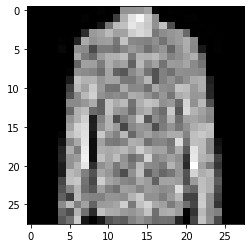

In [ ]:
# Comment out these lines during exercise
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# Uncomment these lines during exercise
# classes = [
#     "0",
#     "1",
#     "2",
#     "3",
#     "4",
#     "5",
#     "6",
#     "7",
#     "8",
#     "9",
# ]

model.eval()
x, y = test_data[101][0], test_data[101][1]
with torch.no_grad():
  pred = model(x)
  predicted, actual = classes[pred[0].argmax(0)], classes[y]
  plt.imshow(x.squeeze(), cmap='gray')
  print(f'Predicted: "{predicted}", Actual: "{actual}"')

# Exercise

In the data prep and prediction sections, comment/uncomment the indicated lines and re-run the notebook. Does the change in behavior surprise you?